In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

overwrite_figures = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1540, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1540, rho=1000, sigma=0, scale=0.0001, label=0)
t1 = tissue.Tissue(name='t1', c=1540, rho=1000, sigma=0, scale=0.0001, label=1)
t2 = tissue.Tissue(name='t2', c=1540, rho=1000, sigma=15, scale=0.0001, label=2)
t3 = tissue.Tissue(name='t3', c=1540, rho=1000, sigma=30, scale=0.0001, label=3)
t4 = tissue.Tissue(name='t4', c=1540, rho=1000, sigma=45, scale=0.0001, label=4)
t5 = tissue.Tissue(name='t5', c=1540, rho=1000, sigma=60, scale=0.0001, label=5)

pos = 0.008
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((0,-2*pos,0), 8, t1)
test_phantom.add_tissue_sphere((0,-pos,0), 8, t2)
test_phantom.add_tissue_sphere((0,0,0), 8, t3)
test_phantom.add_tissue_sphere((0,pos,0), 8, t4)
test_phantom.add_tissue_sphere((0,2*pos,0), 8, t5)
test_phantom.add_tissue_sphere((2*pos,-2*pos,0), 12, t5)
test_phantom.add_tissue_sphere((2*pos,-pos,0), 12, t4)
test_phantom.add_tissue_sphere((2*pos,0,0), 12, t3)
test_phantom.add_tissue_sphere((2*pos,pos,0), 12, t2)
test_phantom.add_tissue_sphere((2*pos,2*pos,0), 12, t1)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

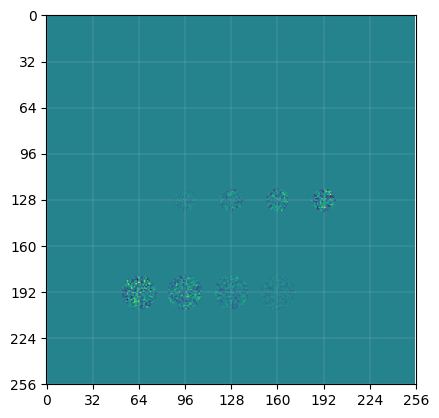

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [4]:
import math

def fibonacci_sphere(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        x = 1 - (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        radius = math.sqrt(1 - x * x)
        theta = phi * i
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

In [5]:
num_transducers = 100
transducers = [transducer.Focused(max_frequency=1e6,
                                    elements = 1, 
                                    width = 1e-3,
                                    height =  1e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = 0,
                                    ray_num = 1,
                                    imaging_ndims = 2,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])
    
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [6]:
coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi / 2)

for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, geometry.Transform(angle, coord * 0.04, intrinsic=False))

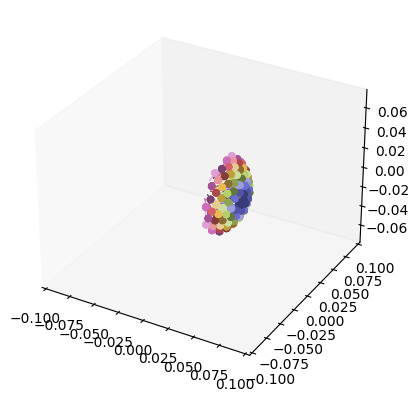

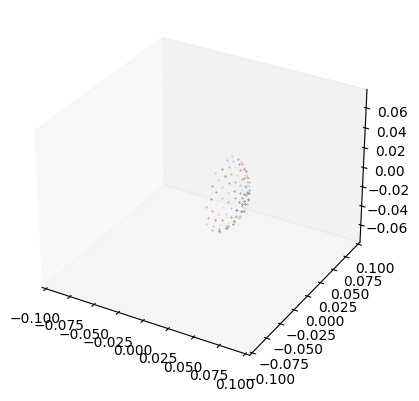

In [7]:
# cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
# count = 0
# spacing = 0.005
# for i in np.linspace(-dim[0]/2,dim[0]/2,dim[0]):
#     for j in np.linspace(-dim[1]/2,dim[1]/2,dim[1]):
#         cont_transducer_set.assign_pose(count, geometry.Transform([0,0,0], [-0.025, spacing*i, spacing*j]))
#         count += 1
        
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [8]:
extended_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

In [9]:
simprops = simulation.SimProperties(
                grid_size   = (60e-3,50e-3,50e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [10]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'spherical_tomography_test_3d',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

extended_experiment.save()

[Text(0, 0, '0.064'), Text(0, 256, '0')]

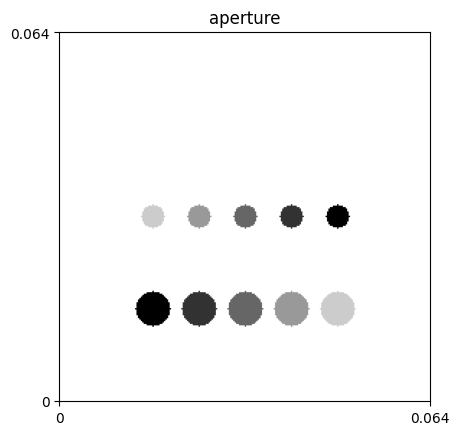

In [11]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','0.064'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['0.064','0'])
# plt.savefig('contrast_phantom.png', dpi=300, bbox_inches="tight")

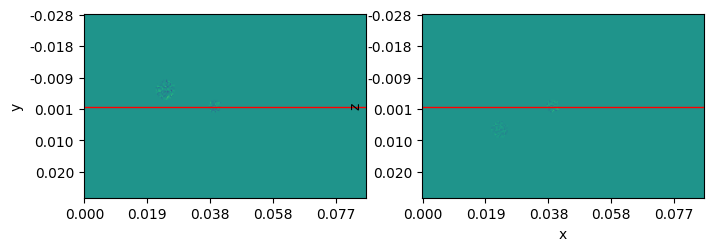

In [12]:
extended_experiment.plot_ray_path(10)

In [13]:
test_experiment = experiment.Experiment.load('spherical_tomography_test_3d')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

Number of simulation results (49) is less than the expected number of simulation results (100), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 100/100 [00:09<00:00, 10.47it/s]

running with 2 workers



preparation for sim    0 completed in  7.14 seconds
preparation for sim    1 completed in  7.65 seconds
simulation             0 completed in  9.03 seconds
simulation             1 completed in  8.97 seconds
preparation for sim    2 completed in  7.69 seconds
preparation for sim    3 completed in  7.64 seconds
simulation             2 completed in  8.89 seconds
preparation for sim    4 completed in  7.51 seconds
simulation             3 completed in  8.94 seconds
simulation             4 completed in  8.91 seconds
preparation for sim    5 completed in  7.67 seconds
simulation             5 completed in  8.90 seconds
preparation for sim    6 completed in  7.66 seconds
simulation             6 completed in  8.90 seconds
preparation for sim    7 completed in  7.63 seconds
simulation             7 completed in  8.94 seconds
preparation for sim    8 completed in  7.51 seconds
preparation for sim    9 completed in  7.57 seconds
simulation             8 completed in  8.93 seconds
preparation 

# Reconstruction

In [14]:
test_experiment = experiment.Experiment.load('spherical_tomography_test_3d')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


In [26]:
# images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False, attenuation_factor=8)
images1 = test_reconstruction.compound(workers=8, resolution_multiplier=1, local=True, combine=False, attenuation_factor=16, volumetric=True)

100%|██████████| 100/100 [00:00<00:00, 662607.27it/s]


In [27]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)/(len(images1)//3)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)/(len(images1)//3)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)/(len(images1)//3)

In [28]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,114:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:114] = 0
sensor_mask2[:,228:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:228] = 0

100%|██████████| 256/256 [00:00<00:00, 2764.93it/s]


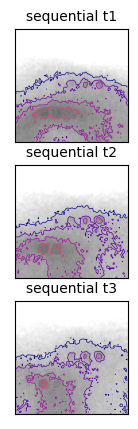

In [29]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image1t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[0].set_title('sequential t1', fontsize=10)

psf = 20 * np.log10(image1t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[1].set_title('sequential t2', fontsize=10)

psf = 20 * np.log10(image1t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[2].set_title('sequential t3', fontsize=10)

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_individual_contrast.png', dpi=300, bbox_inches="tight")

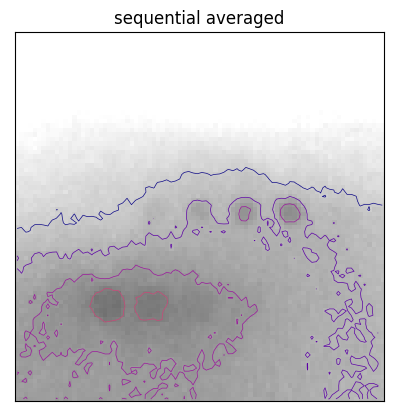

In [30]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])

ax.set_title('sequential averaged')

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_contrast.png', dpi=300, bbox_inches="tight")

In [31]:
image1.shape

(84, 84, 42)

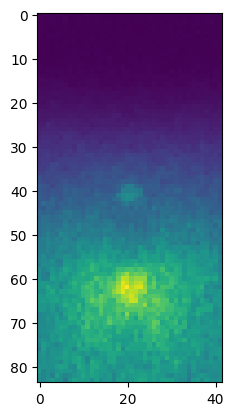

In [32]:
plt.imshow(image1[:, image1.shape[1]//2, :])

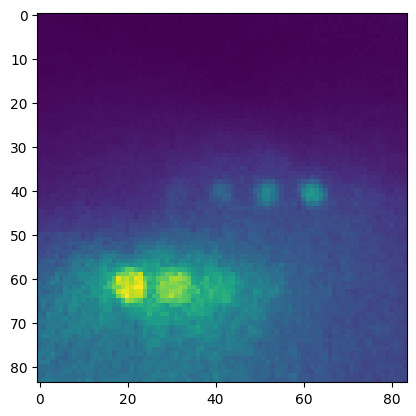

In [33]:
plt.imshow(image1[:,:,21])